In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from  skimage.segmentation import watershed as skwater

def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

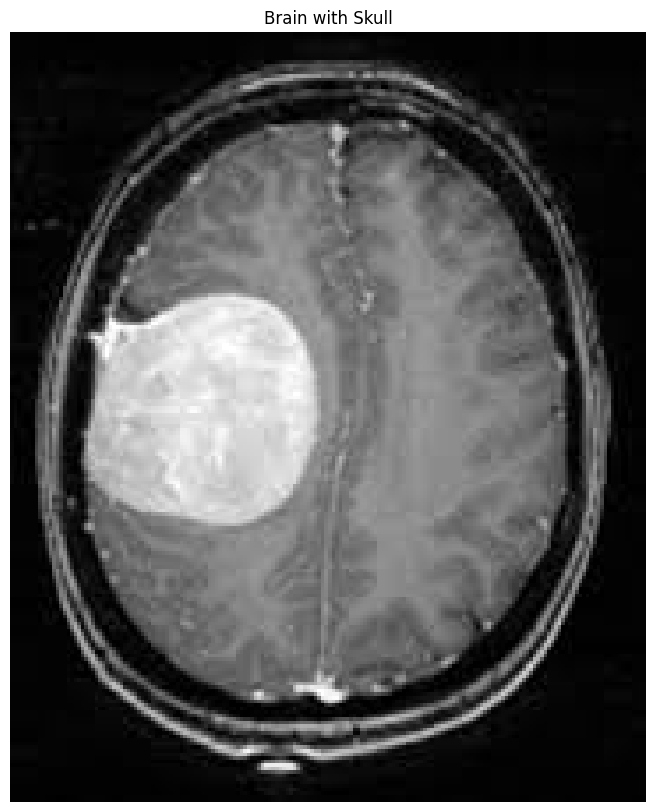

In [11]:
img           = cv2.imread('Y1.jpg')
ShowImage('Brain with Skull',img,'gray')

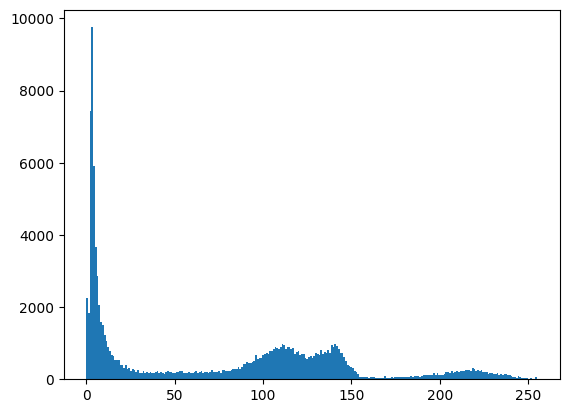

In [13]:
plt.hist(img.ravel(),256)
plt.show()

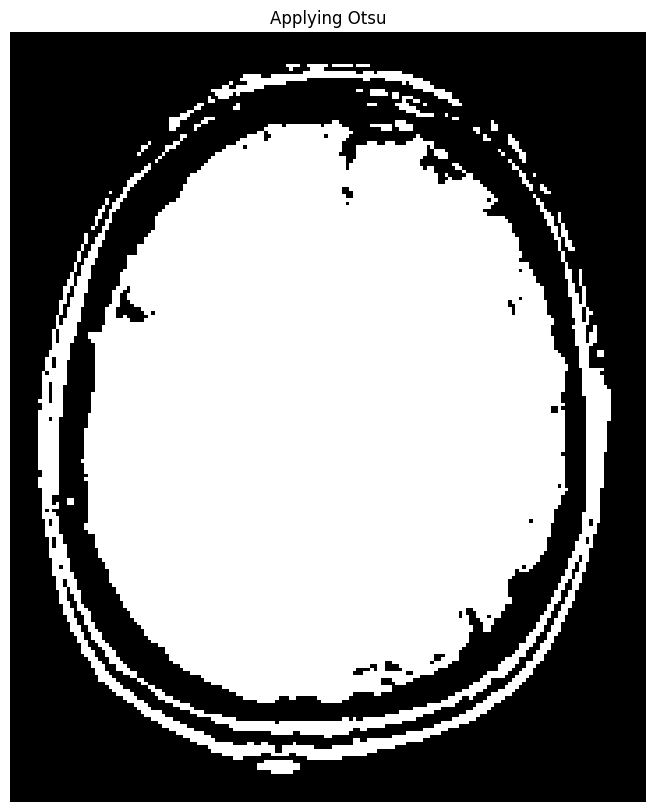

In [14]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ShowImage('Applying Otsu',thresh,'gray')

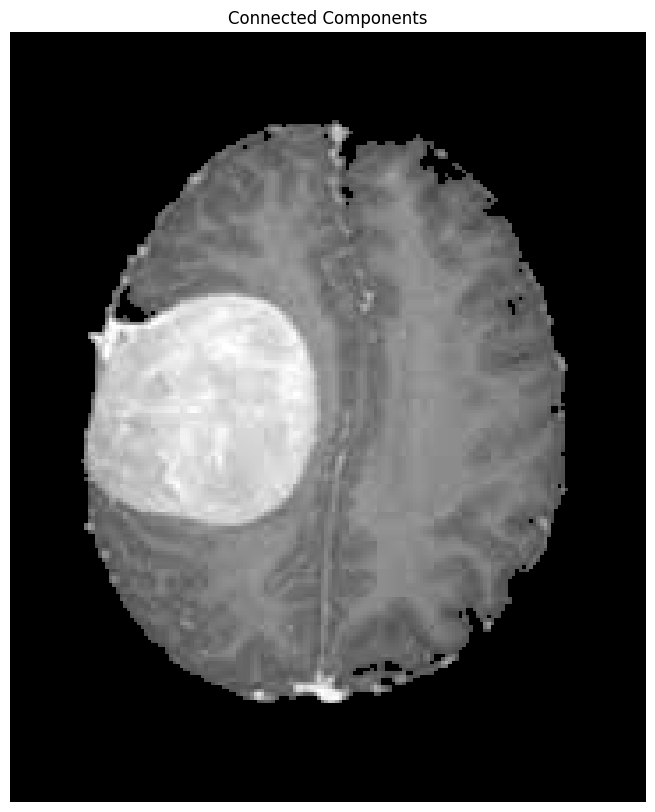

In [15]:
ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[brain_mask==False] = (0,0,0)
ShowImage('Connected Components',brain_out,'rgb')

In [17]:
! pip install -U scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.0 MB 3.4 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.0 MB 3.7 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.0 MB 3.7 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/11.0 MB 3.8 MB/s eta 0:00:02
   --------------- ------------------------ 4.2/11.0 MB 3.8 MB/s eta 0:00:02
   ----------------- ---------------------- 4.7/11.0 MB 3.4 MB/s eta 0:00:02
   ------------------- -------------------- 5.2/11.0 MB 3.5 MB/s eta 0:00:02
   ------------------------- -------------- 7.1/11.0 MB 3.9 MB/s eta 0:00:02
   --------------------------- ------------ 7.6/11.0 MB 3.8 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.0 MB 3.8 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 3.8 MB/s eta 0:00:01
   ----------

In [19]:
! pip install scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   ---------------------------------------- 920.8/920.8 kB 3.2 MB/s eta 0:00:00


In [95]:
from sklearn.cluster import KMeans
import skfuzzy as fuzz
import cv2 
import numpy as np

def k_means_segmentation(img, n_clusters=2):
    img_reshaped = img.reshape((-1, 1))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(img_reshaped)
    segmented = kmeans.labels_.reshape(img.shape)
    return (segmented == 1).astype(np.uint8) * 255  # Assuming tumor is the second cluster

def fuzzy_c_means_segmentation(img, n_clusters=2):
    img_reshaped = img.reshape((-1, 1))
    _, u, _, _, _, _, _ = fuzz.cluster.cmeans(img_reshaped.T, n_clusters, 2, error=0.005, maxiter=1000)
    segmented = u[1].reshape(img.shape)
    return (segmented > 0.5).astype(np.uint8) * 255


In [96]:
from keras.preprocessing import image



In [97]:
img = image.img_to_array(img, dtype='uint8')
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

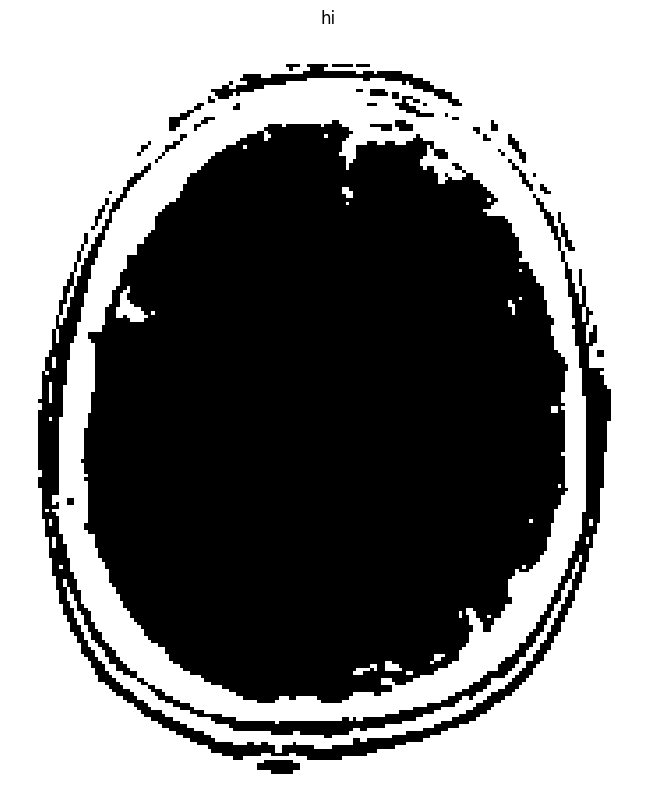

In [98]:
ShowImage('hi',fuzzy_c_means_segmentation(img_grey),'gray')


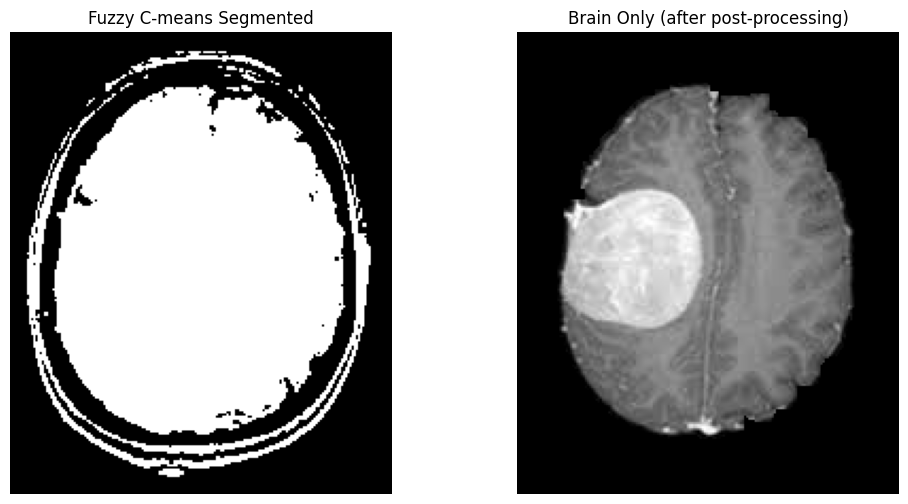

True

In [99]:
segmented = fuzzy_c_means_segmentation(img)

# Ensure that the segmented output is of type CV_8UC1 (1-channel binary image)
segmented =  cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)


# Use morphological operations to remove the skull and isolate the brain
kernel = np.ones((5, 5), np.uint8)
eroded = cv2.erode(segmented, kernel, iterations=1)
dilated = cv2.dilate(eroded, kernel, iterations=2)

# Find contours from the binary image
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask to draw the largest contour (likely the brain)
mask = np.zeros_like(segmented)
largest_contour = max(contours, key=cv2.contourArea)
cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

# Use the mask to extract the brain region from the original image
brain_only = cv2.bitwise_and(img, img, mask=mask)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Fuzzy C-means Segmented')
plt.imshow(segmented, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Brain Only (after post-processing)')
plt.imshow(brain_only, cmap='gray')
plt.axis('off')

plt.show()

# Save the final result
cv2.imwrite('brain_only_segmented.png', brain_only)